In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import*
import py4j

In [2]:
spark = SparkSession\
    .builder\
    .config("spark.jars", "/Users/nahidrahman/opt/miniconda3/lib/python3.9/site-packages/pyspark/jars/mysql-connector-j-8.0.31.jar")\
    .appName("creditcard")\
    .getOrCreate()

23/11/04 22:22:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/04 22:22:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
#Loading json files for the branch, customer, and credit data and creating Pyspark dataframes

df_branch = spark.read.format("json") \
    .option("header", True) \
    .load("cdw_sapp_branch.json")

df_custmer = spark.read.format("json") \
    .option("header", True) \
    .load("cdw_sapp_custmer.json")

df_credit = spark.read.format("json") \
    .option("header", True) \
    .load("cdw_sapp_credit.json")

branch.write.jdbc(url="jdbc:mysql://localhost:3333/my_database" 
"?user=my_user&password=my_password", 
              table="my_table",
              mode="append",
              properties={"driver": 'com.mysql.jdbc.Driver'})

In [5]:
#Writing the branch dataframe into mysql database 

df_branch.write.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
          .option("user", "root") \
            .option("password", "password") \
            .mode("overwrite")\
            .option("driver", 'com.mysql.jdbc.Driver')\
            .save()

Loading class `com.mysql.jdbc.Driver'. This is deprecated. The new driver class is `com.mysql.cj.jdbc.Driver'. The driver is automatically registered via the SPI and manual loading of the driver class is generally unnecessary.


In [8]:
#Writing the custmer dataframe into mysql database 

df_custmer.write.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTMER") \
          .option("user", "root") \
            .option("password", "password") \
            .mode("overwrite")\
            .option("driver", 'com.mysql.jdbc.Driver')\
            .save()

In [12]:
#Adding a new column to the credit dataframe 
#Convert DAY, MONTH, and YEAR into a TIMEID (YYYYMMDD)
from pyspark.sql.functions import concat_ws, lpad

# create a new column called "TIMEID" by concatenating YEAR, MONTH, and DAY columns
df_credit = df_credit.withColumn("TIMEID", concat_ws("", "YEAR", lpad("MONTH", 2, "0"), lpad("DAY", 2, "0")))

# display the new data frame with the TIMEID column drop the others
df_credit.show(1)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|  TIMEID|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|20180214|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
only showing top 1 row



In [ ]:
#Writing the credit dataframe into mysql database 

df_credit.write.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT") \
          .option("user", "root") \
            .option("password", "password") \
            .mode("overwrite")\
            .option("driver", 'com.mysql.jdbc.Driver')\
            .save()

import numpy as np 
import matplotlib.pyplot as plt

#Make a list of all the unqiue transactions 
list_of_transactions = df_credit.select('transaction_type').distinct().rdd.map(lambda r: r[0]).collect()


In [7]:
#Make a list of all the unqiue transactions 
list_of_transactions = df_credit.select('transaction_type').distinct().rdd.map(lambda r: r[0]).collect()
list_of_transactions


['Education', 'Entertainment', 'Healthcare', 'Grocery', 'Test', 'Gas', 'Bills']

+----------+-----+
|CUST_STATE|count|
+----------+-----+
|        NY|   96|
|        GA|   73|
|        PA|   72|
|        FL|   64|
|        IL|   58|
|        NJ|   53|
|        MD|   50|
|        CA|   45|
|        MI|   44|
|        OH|   44|
|        VA|   39|
|        NC|   37|
|        TX|   33|
|        MA|   33|
|        SC|   30|
|        WI|   29|
|        MN|   28|
|        MS|   24|
|        IA|   21|
|        KY|   17|
+----------+-----+
only showing top 20 rows



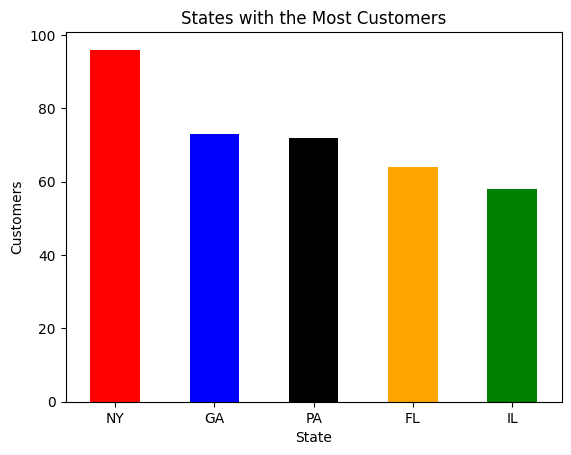

In [11]:
import pandas as pd
from pyspark.sql.functions import count

#Create a pyspark dataframe showing which states has the most customers 
df_custmer.groupBy("CUST_STATE").count().sort('count', ascending = False).show()

#Convert the dataframe into a pandas dataframe
states = (df_custmer.groupBy("CUST_STATE").count().sort('count', ascending = False)).toPandas()

#filter the dataframe to show only the top 5 values 
top5_states = states.loc[states['count'] >53] 

#Create 2 lists based on the dataframe
#states_list = top5_states['CUST_STATE'].toList()
#count_list = top5_states['count'].toList()
c = ['red', 'blue', 'black', 'orange', 'green']
states_plot = top5_states.plot.bar(x='CUST_STATE', y='count', title= 'States with the Most Customers', rot=0, color= c, legend=None, xlabel='State', ylabel='Customers')

In [13]:
df_branch.createTempView("branch")
df_credit.createTempView("credit")
df_custmer.createTempView("customer")

+-----------------+
|sum(total_amount)|
+-----------------+
|         53184.55|
+-----------------+

+---------+------------+
| cust_ssn|total_amount|
+---------+------------+
|123451125|     5633.07|
+---------+------------+



<Axes: title={'center': 'Customer with the Highest Transaction Amount'}, xlabel='cust_ssn'>

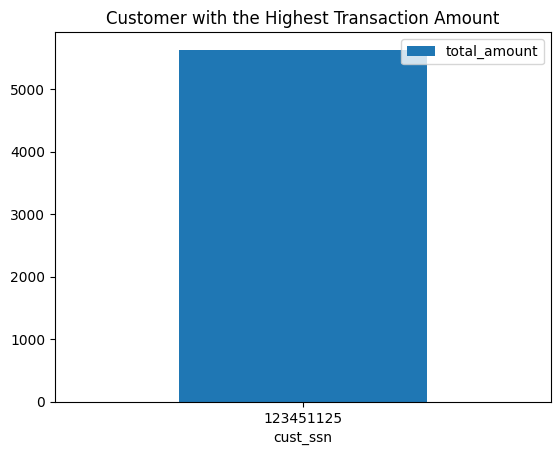

In [14]:
#Find and plot the sum of all transactions for the top 10 customers, and which customer has the highest transaction amount (hint: use CUST_SSN). 

#Used subquery to get the sum of the top 10 customers 
spark.sql("SELECT sum(total_amount) FROM (SELECT cust_ssn, ROUND(sum(transaction_value),2) as total_amount FROM credit GROUP BY cust_ssn ORDER by 2 desc LIMIT 10)").show()

#Which customer has the highest transaction amount
spark.sql("SELECT cust_ssn, ROUND(sum(transaction_value),2) as total_amount FROM credit GROUP BY cust_ssn ORDER by 2 desc LIMIT 1").show()

#Create plot, first convert to pandas 
highest_customer = spark.sql("SELECT cust_ssn, ROUND(sum(transaction_value),2) as total_amount FROM credit GROUP BY cust_ssn ORDER by 2 desc LIMIT 1").toPandas()
highest_customer.plot.bar(x='cust_ssn', y='total_amount', rot=0, title= "Customer with the Highest Transaction Amount")

In [16]:
import requests
import json
from pandas.io.json import json_normalize
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, DoubleType, ArrayType, DataType


api_url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
response = requests.get(api_url)

In [20]:
response.status_code

200

In [17]:
cdw_sapp_loan = response.json()

df_loan = spark.createDataFrame(cdw_sapp_loan)

In [13]:
with open('cdw_sapp_loan.json', 'w') as out_file:
     json.dump(cdw_sapp_loan, out_file) 

In [18]:
df_loan.show()

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1|    Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001006|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|
|      LP001008|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|


In [18]:
#Writing the loan dataframe into the mysql database

df_loan.write.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "creditcard_capstone.CDW_SAPP_LOAN") \
          .option("user", "root") \
            .option("password", "password") \
            .mode("overwrite")\
            .option("driver", 'com.mysql.jdbc.Driver')\
            .save()

Loading class `com.mysql.jdbc.Driver'. This is deprecated. The new driver class is `com.mysql.cj.jdbc.Driver'. The driver is automatically registered via the SPI and manual loading of the driver class is generally unnecessary.


In [19]:
df_loan.createTempView('loan')


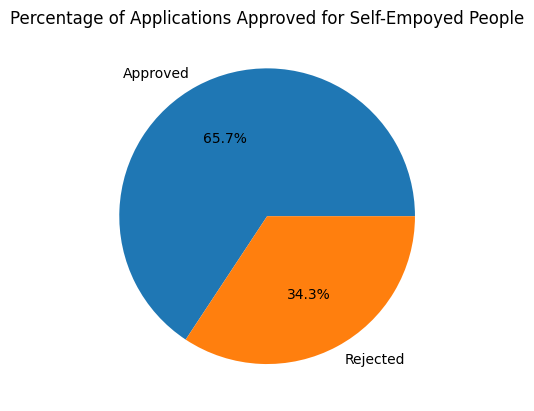

In [20]:
#Finding and plotting the percentage of applications approved for self-employed applicants.

#Query dataframe to get the app status for all people who are self_employed, then convert it to a pandas dataframe and store into a variable
status_self_employed = (spark.sql("SELECT Application_status FROM loan WHERE self_employed = 'Yes'")).toPandas()

#Got the amount of Y and N for the application status
status_count = status_self_employed.value_counts()

#Converted the counts into percetnages using map
percentage_status = status_count.map( lambda x: x/70)

#Pie chart showing the percentage of applications approved vs. rejected for self-employed people
percentage_status.plot(kind= 'pie', title= 'Percentage of Applications Approved for Self-Empoyed People', autopct = '%.1f%%', labels= ('Approved', 'Rejected'))
plt.show()

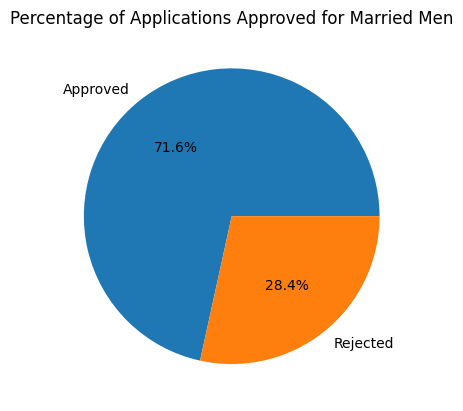

In [21]:
#Finding the percentage of rejection for married male applicants 


status_married_male = (spark.sql("Select application_status FROM loan where (Gender = 'Male' and Married = 'Yes')")).toPandas()

count_status = status_married_male.value_counts()

percentage_status_married_male = count_status.map( lambda x: x/306)
percentage_status_married_male

percentage_status_married_male.plot(kind= 'pie', title= 'Percentage of Applications Approved for Married Men', autopct = '%.1f%%', labels= ('Approved', 'Rejected'))
plt.show()

<Axes: title={'center': 'Months with Most Transactions'}, xlabel='Month', ylabel='Transactions'>

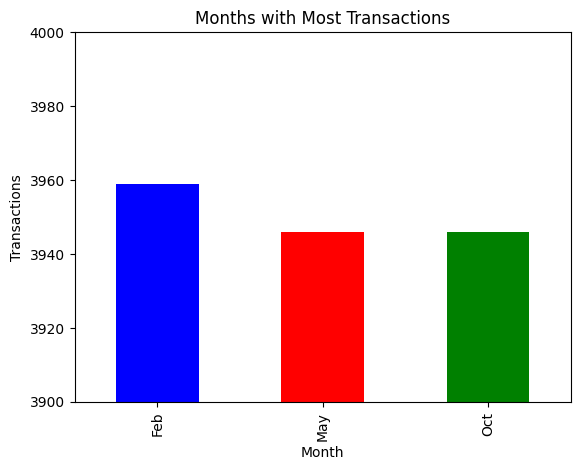

In [22]:
#Find and plot the top three months with the largest transaction data 

#Use SQL query to get the top 3 months with most transactions from credit df 
top3_months = (spark.sql("SELECT month, count(*) as transactions FROM credit GROUP BY month HAVING transactions > 3940 ORDER BY transactions desc")).toPandas()

top3_months.replace(2, 'Feb', inplace= True)
top3_months.replace(5, 'May', inplace= True)
top3_months.replace(10, 'Oct', inplace= True)

top3_months.plot(kind='bar', x='month', y='transactions', ylim=(3900, 4000), title= 'Months with Most Transactions', color=['blue', 'red', 'green'], xlabel='Month', ylabel='Transactions', legend=None)



<Axes: title={'center': 'Branch with Highest Healthcare Transaction Value'}, xlabel='BRANCH_CITY'>

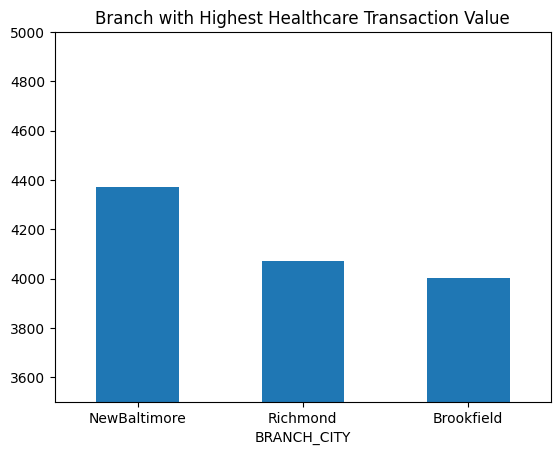

In [24]:
#Find and plot which branch processed the highest total dollar value of healthcare transactions.

healthcare_total_amount = ((spark.sql("SELECT BRANCH_CITY, sum(transaction_value) total_transaction_amount \
FROM credit ct INNER JOIN branch bt on ct.branch_code = bt.branch_code \
WHERE transaction_type = 'Healthcare' GROUP BY BRANCH_CITY HAVING total_transaction_amount > 4000 ORDER BY 2 desc "))).toPandas()

healthcare_total_amount.plot(kind = 'bar', x='BRANCH_CITY', y='total_transaction_amount', title= 'Branch with Highest Healthcare Transaction Value', ylim=(3500, 5000), rot=0, legend=None)

In [45]:
spark.stop

<bound method SparkSession.stop of <pyspark.sql.session.SparkSession object at 0x1071577d0>>